In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import os
import re
import codecs
from IPython.display import display, Math
from six.moves import cPickle as pickle
import string
from PIL import Image
import numpy as np
import h5py
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [3]:
width = None
pd.options.display.max_rows = 600
pd.options.display.max_columns = width
pd.options.display.max_colwidth = 600
pd.options.display.width = width
pd.options.display.max_seq_items = None
pd.options.display.expand_frame_repr = False
pd.options.display.colheader_justify = 'left'

In [4]:
import data_commons as dtc
import dl_commons as dlc
import viz_commons as vc
from viz_commons import VisualizeDir, DiffParams, VisualizeStep

Using TensorFlow backend.


In [22]:
# vd = VisualizeDir(os.path.expanduser('/zpool_3TB/i2l/tb_metrics/2017-11-20 23-11-24 PST 81.76bleu2_3.1LSTM_2init_3OutMLP_3attMLPfull_regroupImage_i=2/store'))
# vd = VisualizeDir(os.path.expanduser('./tb_metrics/2017-11-27 21-20-46 PST scanningRNN_regroupImage/store'))
# vd = VisualizeDir(os.path.expanduser('./tb_metrics/2017-11-28 01-40-26 PST scanningRNN_regroupImage/store'))
vd = VisualizeDir(os.path.expanduser('./tb_metrics/2017-12-02 21-07-08 PST scanningRNN_regroupImage/store'))

Loaded ./tb_metrics/2017-12-02 21-07-08 PST scanningRNN_regroupImage/store/hyper.pkl and ./tb_metrics/2017-12-02 21-07-08 PST scanningRNN_regroupImage/store/args.pkl
Loaded ../data/dataset3/training_56/df_train.pkl (89096, 3)


In [23]:
# vd.hyper
# vs.keys()

In [24]:
vd.view_snapshots()

Num Snapshots: 25
Snapshots = [(1512, 1323.0), (3024, 2646.0), (4536, 3969.0), (6048, 5292.0), (7560, 6615.0), (9072, 7938.0), (10584, 9261.0), (12096, 10584.0), (13608, 11907.0), (15120, 13230.0), (16632, 14553.0), (18144, 15876.0), (19656, 17199.0), (21168, 18522.0), (22680, 19845.0), (24192, 21168.0), (25704, 22491.0), (27216, 23814.0), (28728, 25137.0), (30240, 26460.0), (31752, 27783.0), (33264, 29106.0), (34776, 30429.0), (36288, 31752.0), (37800, 33075.0)]


In [25]:
vd.view_steps()

num epoch_steps = 25
epoch_steps = [(1512, 1323.0), (3024, 2646.0), (4536, 3969.0), (6048, 5292.0), (7560, 6615.0), (9072, 7938.0), (10584, 9261.0), (12096, 10584.0), (13608, 11907.0), (15120, 13230.0), (16632, 14553.0), (18144, 15876.0), (19656, 17199.0), (21168, 18522.0), (22680, 19845.0), (24192, 21168.0), (25704, 22491.0), (27216, 23814.0), (28728, 25137.0), (30240, 26460.0), (31752, 27783.0), (33264, 29106.0), (34776, 30429.0), (36288, 31752.0), (37800, 33075.0)]
all_steps = [(100, 87.5), (200, 175.0), (300, 262.5), (400, 350.0), (500, 437.5), (600, 525.0), (700, 612.5), (800, 700.0), (900, 787.5), (1000, 875.0), (1100, 962.5), (1200, 1050.0), (1300, 1137.5), (1400, 1225.0), (1500, 1312.5), (1512, 1323.0), (1512, 1323.0), (1600, 1400.0), (1700, 1487.5), (1800, 1575.0), (1900, 1662.5), (2000, 1750.0), (2100, 1837.5), (2200, 1925.0), (2300, 2012.5), (2400, 2100.0), (2500, 2187.5), (2600, 2275.0), (2700, 2362.5), (2800, 2450.0), (2900, 2537.5), (3000, 2625.0), (3024, 2646.0), (3024, 

In [26]:
vs = VisualizeStep(vd, 'validation', 37800)
vs.strs('predicted_ids', trim=True)

,_id,edit_distance,len,predicted_ids
4,0,0.000000,85,"\Sigma =r^{2}+a^{2}\operatorname {cos}^{2}\theta +2(Na\operatorname {cos}\theta +Mr),"
5,1,0.152174,49,"[W_{0}]=2E_{1}+E_{2}+E}{3}+n,,\qquad [W_{T}(1-F)F"
2,2,0.155556,52,ds^{2}=e^{2A)}_{g}_{\mu }x}dx^{\mu ^dx^{\nu }+dy^{2}
49,3,0.166667,112,"1H_{\mu \nu \mu }\equiv \partial _{\mu }B_{\nu \partial }+\partial }{B}{B_{\mu }+\partial _{\mu }B_{\mu \nu }=0,"
19,4,0.166667,58,"D_{\mu }h_{a}=(\partial _{\mu }+iq_{a}{a_{\mu _{h_{ai}\, ."
11,5,0.195122,92,"ds^{2}=\left( \frac {d\frac {d\pi }{d\tau }\right) ^{2^\tau ^{2}\equiv h(\tau )d\tau ^{2}\,,"
36,6,0.214286,52,(V^{0}V^{1})^{\prime }=e^{\pm ^{V}(V^{0}\pm V^{1}}).
51,7,0.219512,54,"F_{0}(x,y)=e^{2k|}\left( 1+l^+l}f}{f}(y(y)\right) x(x)"
21,8,0.222222,62,"[\gamma ^{0},0{\cal }(X}X}]=0,\{ \gamma ^{0},{\cal Q}(X})\} =0"
48,9,0.224490,92,\gamma _{\gamma }=\frac {1}{2}(A_{}-B_{+})=\left( \frac {\frac {-1}-1}{1}\right) \sqrt {-}}.


CustomConvnetImageProcessor: image_batch_shape = (1, 128, 1088, 1), image_shape_unframed = [128, 1088, 1]


<IPython.core.display.Math object>

\Sigma =r^{2}+a^{2}\operatorname {cos}^{2}\theta +2(Na\operatorname {cos}\theta +Mr),


<IPython.core.display.Math object>

\Sigma =r^{2}+a^{2}\operatorname {cos}^{2}\theta +2(Na\operatorname {cos}\theta +Mr),


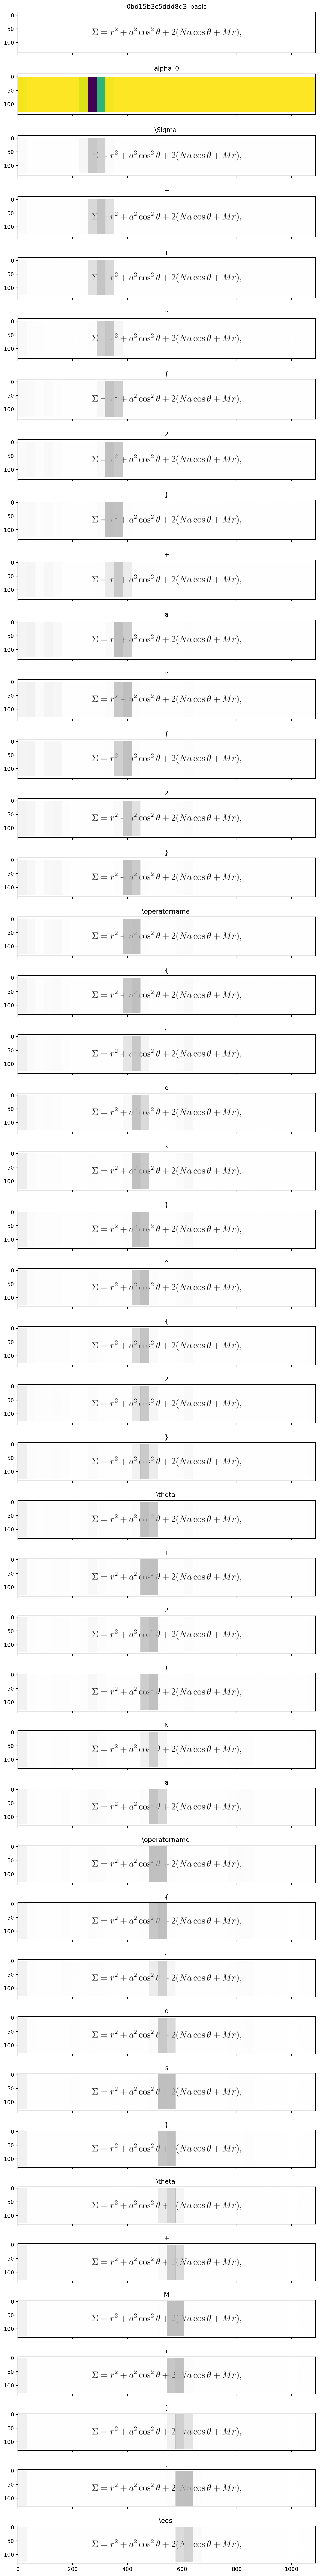

In [27]:
nd_alpha = vs.alpha(invert_alpha=True)

In [ ]:
vd.unstandardize_step(132300)